# An√°lise Espectrosc√≥pica Multilayer Perceptron

Este notebook segue as melhores pr√°ticas da literatura para an√°lise espectrosc√≥pica robusta, incluindo:
- Divis√£o dos dados por Kennard-Stone (70-30)
- Remo√ß√£o de outliers espectrais (PCA, T¬≤/Q)
- Remo√ß√£o de outliers dos atributos (boxplot + seaborn)
- Teste de todos os filtros (dependentes e independentes de y)
- Modelagem MLPR com TODOS os filtros dispon√≠veis (an√°lise completa)
- Plotagens robustas e salvamento de m√©tricas

## 1. Imports

In [1]:
# Imports necess√°rios
import os
import pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy.spatial.distance import cdist
from scipy.signal import savgol_filter, detrend
import warnings
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
import time

warnings.filterwarnings('ignore')

# Configura√ß√µes de plot
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Carregamento dos Dados

A etapa inicial consiste em carregar os dados do arquivo Excel. A fun√ß√£o `load_data` realiza a separa√ß√£o crucial entre:
-   `metadata`: As vari√°veis de refer√™ncia (alvo ou **y**), como pH, SST, Firmeza, etc.
-   `wavelengths`: Os dados espectrais (preditoras ou **X**), que representam a absorb√¢ncia/reflect√¢ncia em cada comprimento de onda.

Essa separa√ß√£o organiza os dados para as etapas subsequentes de pr√©-processamento e modelagem.

In [2]:
# Fun√ß√£o para carregar dados
def load_data(filepath):
    """Carrega dados espectrais e separa metadados de espectros."""
    df = pd.read_excel(filepath, engine='openpyxl')
    
    # Identificar colunas que s√£o comprimentos de onda (num√©ricas)
    numeric_cols = []
    for col in df.columns:
        try:
            float(col)
            numeric_cols.append(col)
        except ValueError:
            continue
    
    # Separar metadados e comprimentos de onda
    metadata = df.drop(columns=numeric_cols)
    wavelengths = df[numeric_cols]
    
    return metadata, wavelengths

# Carregar dados
filepath = 'Data/Original/dataset_cotton_fruit.xlsx'
metadata, wavelengths = load_data(filepath)
X = wavelengths.values
wavelength_values = wavelengths.columns.astype(float)
atributos = ['AT', 'FIRMEZA (N)', 'PH', 'SST', 'UBS (%)']

print(f'Dados carregados: {X.shape[0]} amostras, {X.shape[1]} comprimentos de onda')
print(f'Faixa espectral: {wavelength_values.min():.1f} - {wavelength_values.max():.1f} nm')
print(f'Atributos dispon√≠veis: {list(metadata.columns)}')
print(f'Atributos a analisar: {atributos}')

Dados carregados: 250 amostras, 2151 comprimentos de onda
Faixa espectral: 350.0 - 2500.0 nm
Atributos dispon√≠veis: ['Wavelength', 'SST', 'PH', 'AT', 'FIRMEZA (N)', 'UBU (%)', 'UBS (%)']
Atributos a analisar: ['AT', 'FIRMEZA (N)', 'PH', 'SST', 'UBS (%)']


## 3. Divis√£o dos Dados com Kennard-Stone (70-30)

Para treinar e validar o modelo de forma confi√°vel, dividimos os dados usando o algoritmo **Kennard-Stone (KS)**. Diferente de uma divis√£o aleat√≥ria, o KS seleciona amostras para o conjunto de calibra√ß√£o que cobrem a m√°xima variabilidade espectral, criando um modelo mais robusto e generalista.

-   **Rastreamento de Amostras:** O c√≥digo foi ajustado para manter um registro dos **√≠ndices originais** de cada amostra nos conjuntos de calibra√ß√£o e valida√ß√£o. Isso √© fundamental para saber exatamente quais amostras s√£o identificadas como outliers nas pr√≥ximas etapas.
-   **Processo por Atributo:** A divis√£o √© refeita para cada atributo para garantir que amostras com valores ausentes (`NaN`) sejam tratadas corretamente.

In [3]:
def kennard_stone(X, train_size=0.7):
    """Implementa o algoritmo Kennard-Stone para divis√£o de dados."""
    n_samples = X.shape[0]
    n_train = int(n_samples * train_size)
    
    if n_train < 2:
        raise ValueError("O conjunto de treinamento precisa ter pelo menos duas amostras!")
    
    distances = cdist(X, X, metric='euclidean')
    
    mean_sample = np.mean(X, axis=0)
    first_sample = np.argmax(np.linalg.norm(X - mean_sample, axis=1))
    selected = [first_sample]
    
    remaining = list(range(n_samples))
    remaining.remove(first_sample)
    
    for _ in range(1, n_train):
        dist_to_selected = distances[selected, :]
        min_dist_to_selected = np.min(dist_to_selected[:, remaining], axis=0)
        
        next_sample_idx_in_remaining = np.argmax(min_dist_to_selected)
        next_sample = remaining.pop(next_sample_idx_in_remaining)
        
        selected.append(next_sample)
        
    return np.array(selected), np.array(remaining)

# Divis√£o para cada atributo
dados_divididos = {}

for atributo in atributos:
    y = metadata[atributo].values
    original_indices = np.arange(len(y)) # Guarda os √≠ndices originais
    
    mask = ~np.isnan(y)
    X_clean = X[mask]
    y_clean = y[mask]
    original_indices_clean = original_indices[mask] # Filtra os √≠ndices tamb√©m
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)
    
    idx_cal_split, idx_val_split = kennard_stone(X_scaled, train_size=0.7)
    
    X_cal, X_val = X_clean[idx_cal_split], X_clean[idx_val_split]
    y_cal, y_val = y_clean[idx_cal_split], y_clean[idx_val_split]
    
    # Guarda os √≠ndices originais de cada conjunto
    indices_orig_cal = original_indices_clean[idx_cal_split]
    indices_orig_val = original_indices_clean[idx_val_split]
    
    dados_divididos[atributo] = {
        'X_cal': X_cal, 'X_val': X_val,
        'y_cal': y_cal, 'y_val': y_val,
        'indices_orig_cal': indices_orig_cal,
        'indices_orig_val': indices_orig_val
    }
    
    print(f'{atributo}: {X_cal.shape[0]} calibra√ß√£o, {X_val.shape[0]} valida√ß√£o')

print(f'\nDivis√£o Kennard-Stone conclu√≠da para {len(atributos)} atributos!')

AT: 175 calibra√ß√£o, 75 valida√ß√£o
FIRMEZA (N): 175 calibra√ß√£o, 75 valida√ß√£o
PH: 175 calibra√ß√£o, 75 valida√ß√£o
SST: 175 calibra√ß√£o, 75 valida√ß√£o
UBS (%): 175 calibra√ß√£o, 75 valida√ß√£o

Divis√£o Kennard-Stone conclu√≠da para 5 atributos!


## 4. Remo√ß√£o de Outliers Espectrais (PCA, T¬≤/Q) nos Dados de Calibra√ß√£o

Outliers espectrais s√£o amostras com perfis an√¥malos que podem distorcer o modelo. Usamos a An√°lise de Componentes Principais (PCA) para detect√°-los, baseando-nos em duas m√©tricas:
-   **Estat√≠stica T¬≤ (Hotelling's T¬≤):** Mede a varia√ß√£o de uma amostra *dentro* do modelo PCA.
-   **Estat√≠stica Q (Res√≠duos):** Mede a varia√ß√£o da amostra *fora* do modelo, ou seja, o que o PCA n√£o conseguiu modelar.

Uma amostra √© marcada como outlier se exceder os limites estat√≠sticos (m√©dia + 3 desvios padr√£o) de T¬≤ ou Q.

**Ponto Chave:** Esta limpeza √© feita **apenas no conjunto de calibra√ß√£o**.

In [4]:
def pca_outlier_removal(X, n_components=10, threshold=3):
    """Remove outliers usando PCA com estat√≠sticas T¬≤ e Q."""
    # Padronizar dados
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Aplicar PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Calcular estat√≠stica T¬≤ (Hotelling's T¬≤)
    T2 = np.sum((X_pca / np.std(X_pca, axis=0)) ** 2, axis=1)
    
    # Calcular estat√≠stica Q (res√≠duos)
    X_reconstructed = pca.inverse_transform(X_pca)
    Q = np.sum((X_scaled - X_reconstructed) ** 2, axis=1)
    
    # Definir limites (m√©dia + threshold * desvio padr√£o)
    T2_limit = np.mean(T2) + threshold * np.std(T2)
    Q_limit = np.mean(Q) + threshold * np.std(Q)
    
    # Identificar outliers
    outliers_mask = (T2 > T2_limit) | (Q > Q_limit)
    
    # Retornamos a m√°scara de quem N√ÉO √© outlier e o modelo PCA treinado
    return ~outliers_mask, pca, T2, Q, T2_limit, Q_limit

# Remover outliers espectrais dos dados de calibra√ß√£o
dados_pca = {}

for atributo in atributos:
    X_cal = dados_divididos[atributo]['X_cal']
    y_cal = dados_divididos[atributo]['y_cal']
    indices_orig_cal = dados_divididos[atributo]['indices_orig_cal']
    
    # Chama a fun√ß√£o de remo√ß√£o de outliers e armazena todos os resultados
    keep_mask, pca_model, T2, Q, T2_limit, Q_limit = pca_outlier_removal(X_cal)
    
    # Identifica e informa os outliers removidos
    outliers_indices = indices_orig_cal[~keep_mask]
    print(f'{atributo}: {len(outliers_indices)} outliers espectrais removidos da calibra√ß√£o.')
    if len(outliers_indices) > 0:
        print(f'  √çndices Originais Removidos: {outliers_indices}')
    
    # Filtra os dados de calibra√ß√£o
    X_cal_clean = X_cal[keep_mask]
    y_cal_clean = y_cal[keep_mask]
    indices_orig_cal_clean = indices_orig_cal[keep_mask]
    
    dados_pca[atributo] = {
        'X_cal': X_cal_clean,
        'y_cal': y_cal_clean,
        'indices_orig_cal': indices_orig_cal_clean,
        'pca_model': pca_model,
        'T2': T2,
        'Q': Q,
        'T2_limit': T2_limit,
        'Q_limit': Q_limit,
        'keep_mask': keep_mask
    }
    
    print(f'  Calibra√ß√£o: {X_cal_clean.shape[0]} amostras')
    print(f'  Valida√ß√£o: {dados_divididos[atributo]["X_val"].shape[0]} amostras')
    print()


AT: 7 outliers espectrais removidos da calibra√ß√£o.
  √çndices Originais Removidos: [ 78  74  67  52 237  75  93]
  Calibra√ß√£o: 168 amostras
  Valida√ß√£o: 75 amostras

FIRMEZA (N): 7 outliers espectrais removidos da calibra√ß√£o.
  √çndices Originais Removidos: [ 78  74  67  52 237  75  93]
  Calibra√ß√£o: 168 amostras
  Valida√ß√£o: 75 amostras

PH: 7 outliers espectrais removidos da calibra√ß√£o.
  √çndices Originais Removidos: [ 78  74  67  52 237  75  93]
  Calibra√ß√£o: 168 amostras
  Valida√ß√£o: 75 amostras

SST: 7 outliers espectrais removidos da calibra√ß√£o.
  √çndices Originais Removidos: [ 78  74  67  52 237  75  93]
  Calibra√ß√£o: 168 amostras
  Valida√ß√£o: 75 amostras

UBS (%): 7 outliers espectrais removidos da calibra√ß√£o.
  √çndices Originais Removidos: [ 78  74  67  52 237  75  93]
  Calibra√ß√£o: 168 amostras
  Valida√ß√£o: 75 amostras



### 4.1 Verifica√ß√£o de Outliers Espectrais no Conjunto de Valida√ß√£o

Ap√≥s construir o modelo de PCA com os dados de calibra√ß√£o limpos, podemos us√°-lo para avaliar o conjunto de valida√ß√£o. O objetivo aqui **n√£o √© remover** amostras da valida√ß√£o, mas sim entender se ele cont√©m amostras que seriam consideradas "estranhas" pelo modelo.
- **Metodologia:**
    1. Padronizamos os dados de valida√ß√£o usando o `scaler` treinado na calibra√ß√£o.
    2. Projetamos esses dados no espa√ßo PCA do modelo de calibra√ß√£o.
    3. Calculamos as estat√≠sticas T¬≤ e Q para as amostras de valida√ß√£o.
    4. Comparamos esses valores com os **limites (T¬≤_limit e Q_limit) definidos na calibra√ß√£o**.
- **Interpreta√ß√£o:** Se amostras de valida√ß√£o excederem os limites, isso indica que o modelo pode ter dificuldade em prediz√™-las, pois elas representam uma variabilidade n√£o vista (ou removida) no treino. Isso √© uma informa√ß√£o valiosa sobre a robustez do modelo.

In [5]:
# Verifica√ß√£o de Outliers na Valida√ß√£o
print("--- Verifica√ß√£o de Outliers no Conjunto de Valida√ß√£o ---")
for atributo in atributos:
    # Carrega o modelo PCA e os dados de valida√ß√£o
    pca_model = dados_pca[atributo]['pca_model']
    X_val = dados_divididos[atributo]['X_val']
    indices_orig_val = dados_divididos[atributo]['indices_orig_val']
    
    # Recalcula os limites usando o modelo salvo, se necess√°rio
    # (Ou usa os limites j√° calculados e salvos anteriormente)
    
    # Padroniza e projeta os dados de valida√ß√£o
    scaler_val = StandardScaler().fit(dados_divididos[atributo]['X_cal']) # Usa o scaler da calibra√ß√£o
    X_val_scaled = scaler_val.transform(X_val)
    X_val_pca = pca_model.transform(X_val_scaled)

    # Calcula T¬≤ e Q para a valida√ß√£o
    T2_val = np.sum((X_val_pca / np.std(X_val_pca, axis=0)) ** 2, axis=1)
    X_val_reconstructed = pca_model.inverse_transform(X_val_pca)
    Q_val = np.sum((X_val_scaled - X_val_reconstructed) ** 2, axis=1)

    # Identifica outliers da valida√ß√£o usando os limites da CALIBRA√á√ÉO
    outliers_val_mask = (T2_val > T2_limit) | (Q_val > Q_limit)
    outliers_val_indices = indices_orig_val[outliers_val_mask]
    
    print(f'\nAtributo: {atributo}')
    if len(outliers_val_indices) > 0:
        print(f'  {len(outliers_val_indices)} amostras de VALIDA√á√ÉO excedem os limites da calibra√ß√£o.')
        print(f'  √çndices Originais: {outliers_val_indices}')
    else:
        print('  Nenhuma amostra de valida√ß√£o excede os limites da calibra√ß√£o.')

--- Verifica√ß√£o de Outliers no Conjunto de Valida√ß√£o ---

Atributo: AT
  Nenhuma amostra de valida√ß√£o excede os limites da calibra√ß√£o.

Atributo: FIRMEZA (N)
  Nenhuma amostra de valida√ß√£o excede os limites da calibra√ß√£o.

Atributo: PH
  Nenhuma amostra de valida√ß√£o excede os limites da calibra√ß√£o.

Atributo: SST
  Nenhuma amostra de valida√ß√£o excede os limites da calibra√ß√£o.

Atributo: UBS (%)
  Nenhuma amostra de valida√ß√£o excede os limites da calibra√ß√£o.


### 4.2 Gr√°ficos de Outliers T¬≤ e Q

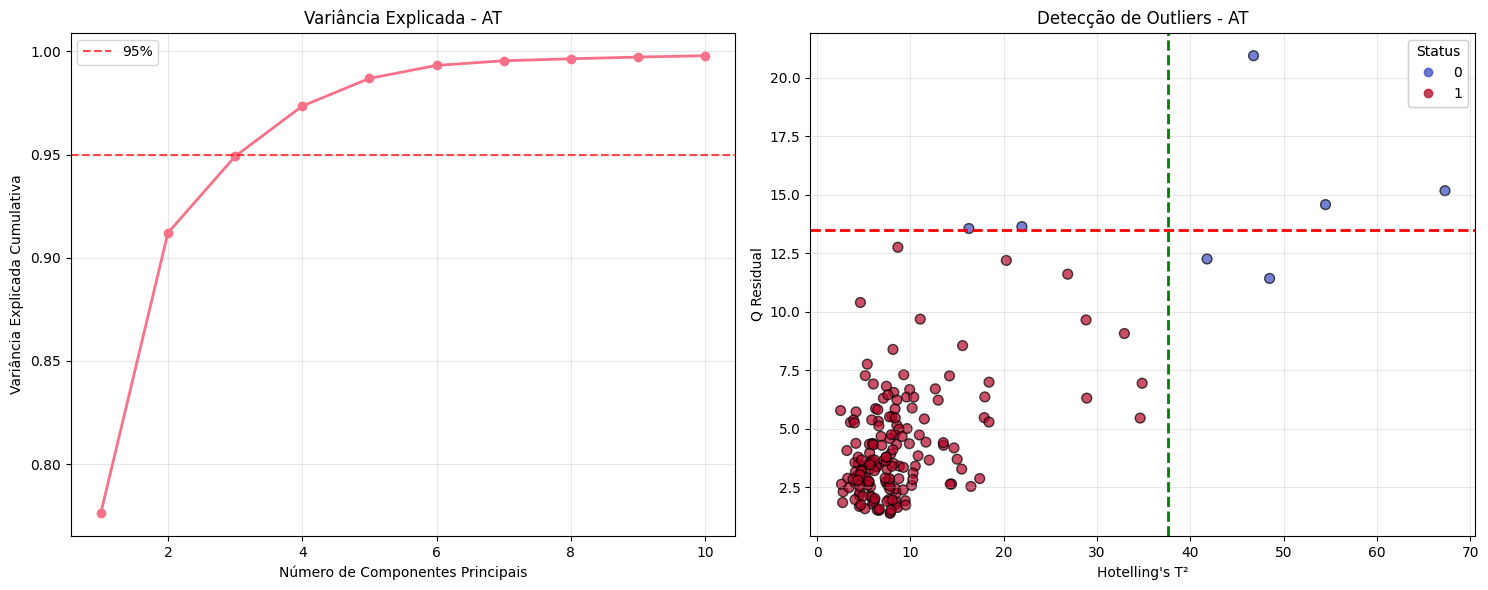

Gr√°ficos de outliers para AT exibidos.



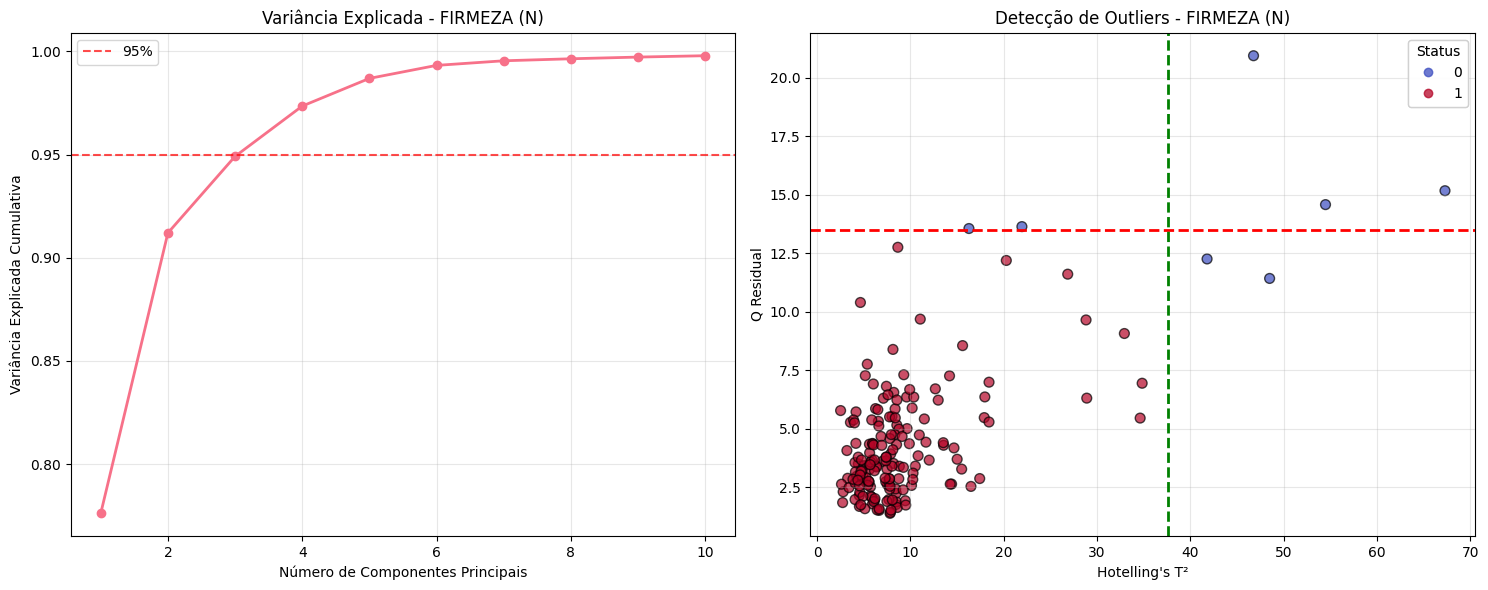

Gr√°ficos de outliers para FIRMEZA (N) exibidos.



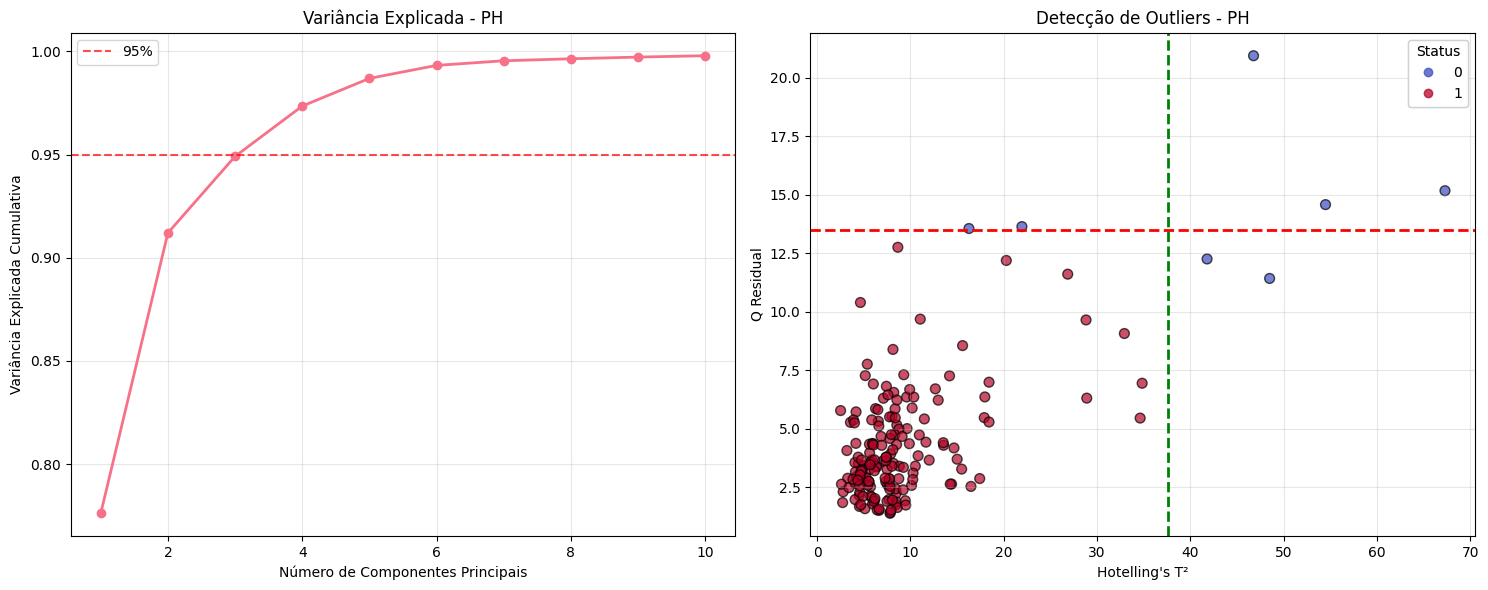

Gr√°ficos de outliers para PH exibidos.



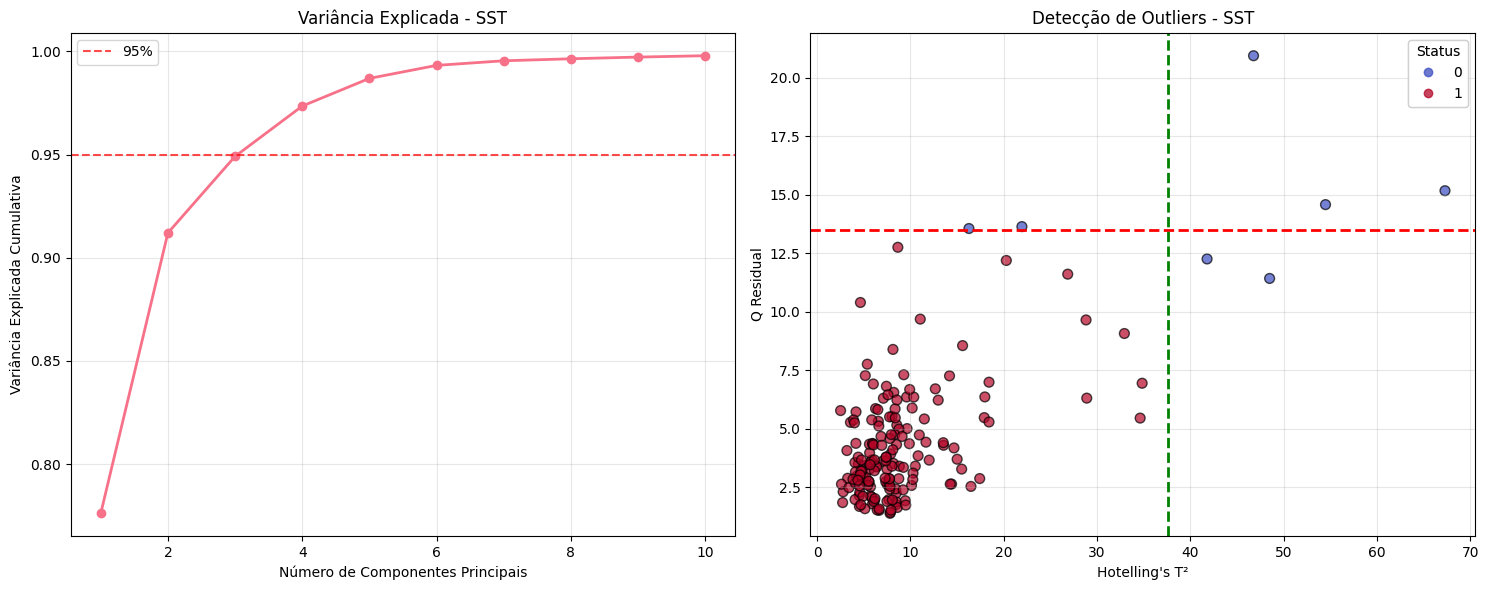

Gr√°ficos de outliers para SST exibidos.



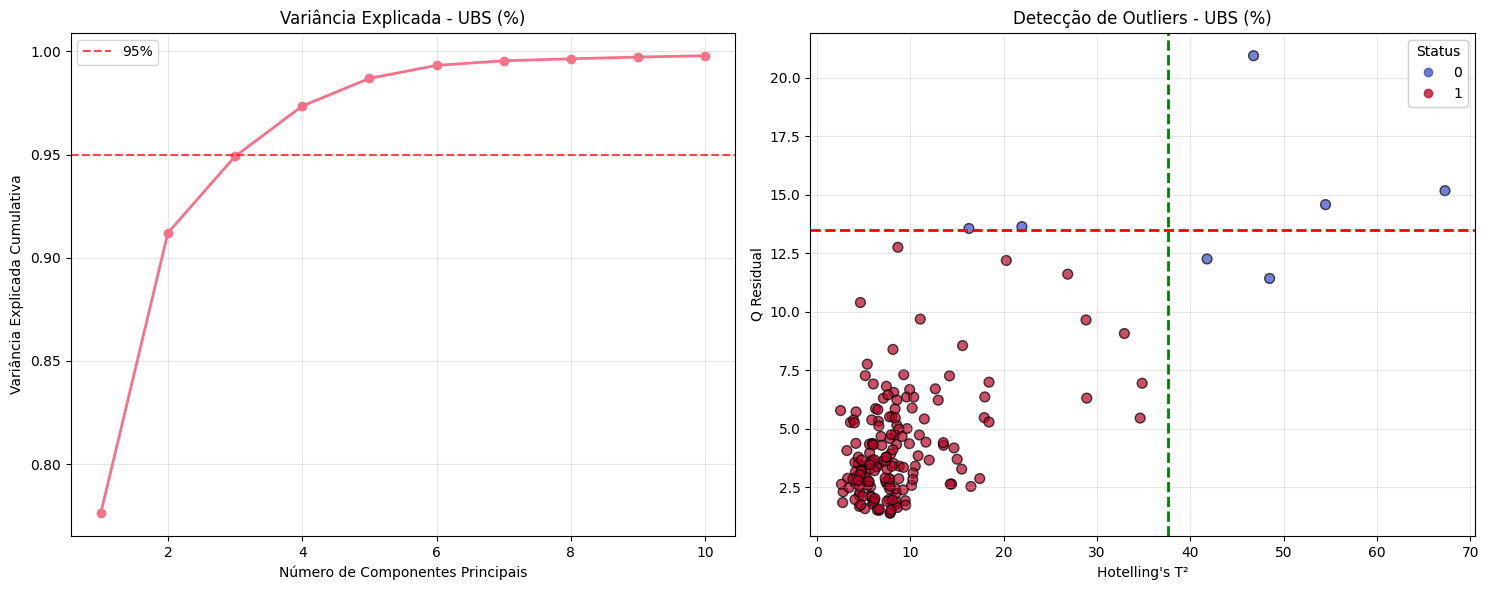

Gr√°ficos de outliers para UBS (%) exibidos.



In [6]:
for atributo in atributos:
    d = dados_pca[atributo]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gr√°fico 1: Vari√¢ncia explicada cumulativa
    # Acessa o modelo PCA com a chave correta 'pca_model'
    cumulative_variance = np.cumsum(d['pca_model'].explained_variance_ratio_)
    axes[0].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o-', linewidth=2, markersize=6)
    axes[0].set_xlabel('N√∫mero de Componentes Principais')
    axes[0].set_ylabel('Vari√¢ncia Explicada Cumulativa')
    axes[0].set_title(f'Vari√¢ncia Explicada - {atributo}')
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0.95, color='r', linestyle='--', alpha=0.7, label='95%')
    axes[0].legend()
    
    # Gr√°fico 2: T¬≤ vs Q (detec√ß√£o de outliers)
    # Acessa as vari√°veis T2, Q, T2_limit, Q_limit e keep_mask com as chaves corretas
    scatter = axes[1].scatter(d['T2'], d['Q'], c=d['keep_mask'], cmap='coolwarm', 
                              edgecolor='k', alpha=0.7, s=50)
    axes[1].axhline(d['Q_limit'], color='r', linestyle='--', linewidth=2, label=f'Q Limit: {d["Q_limit"]:.2f}')
    axes[1].axvline(d['T2_limit'], color='g', linestyle='--', linewidth=2, label=f'T¬≤ Limit: {d["T2_limit"]:.2f}')
    axes[1].set_xlabel("Hotelling's T¬≤")
    axes[1].set_ylabel('Q Residual')
    axes[1].set_title(f'Detec√ß√£o de Outliers - {atributo}')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Adicionar legenda de cores (esta parte tamb√©m foi ajustada para a chave 'keep_mask')
    legend1 = axes[1].legend(*scatter.legend_elements(), title="Status")
    axes[1].add_artist(legend1)
    
    plt.tight_layout()
    plt.show()
    
    print(f'Gr√°ficos de outliers para {atributo} exibidos.')
    print()

## 5. Remo√ß√£o de Outliers dos Atributos (Boxplot + Seaborn)

Al√©m dos outliers espectrais (em X), podemos ter outliers nos valores de refer√™ncia (em y). Por exemplo, um valor de pH ou SST que √© analiticamente improv√°vel ou resultado de um erro de anota√ß√£o.
- **M√©todo (IQR):** O m√©todo do Intervalo Interquartil (IQR) √© uma forma estat√≠stica robusta de identificar esses pontos.
    - `IQR = Q3 (percentil 75) - Q1 (percentil 25)`
    - Um valor √© considerado outlier se estiver abaixo de `Q1 - 1.5 * IQR` ou acima de `Q3 + 1.5 * IQR`.
- **Visualiza√ß√£o:** O `boxplot` √© a ferramenta visual perfeita para essa an√°lise, pois ele desenha os "bigodes" exatamente nesses limites de 1.5 * IQR, mostrando os outliers como pontos individuais.
- **A√ß√£o:** Novamente, a remo√ß√£o √© feita apenas no conjunto de calibra√ß√£o.

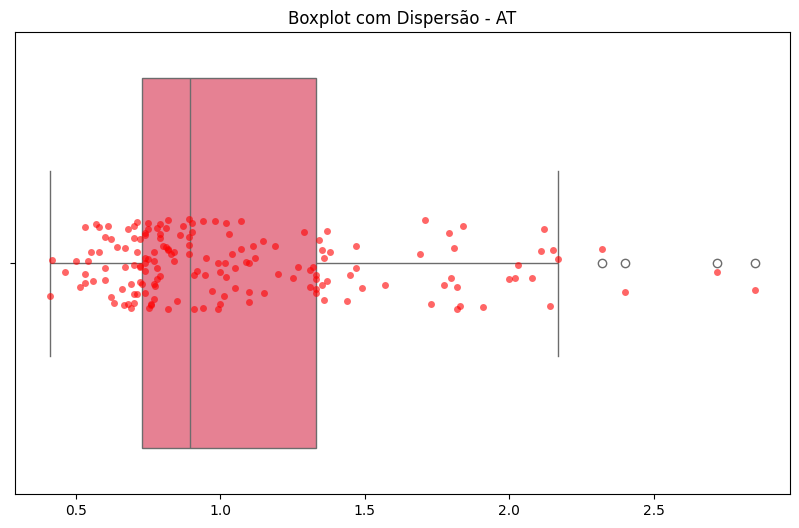

AT: 4 outliers de atributo removidos.
  √çndices Originais Removidos: [15 12 30 19]
  Calibra√ß√£o final: 164 amostras
  Valida√ß√£o: 75 amostras



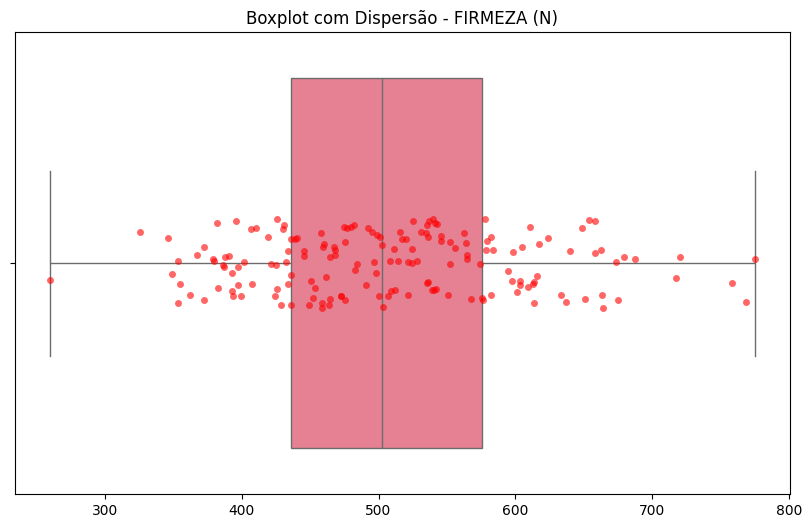

FIRMEZA (N): 0 outliers de atributo removidos.
  Calibra√ß√£o final: 168 amostras
  Valida√ß√£o: 75 amostras



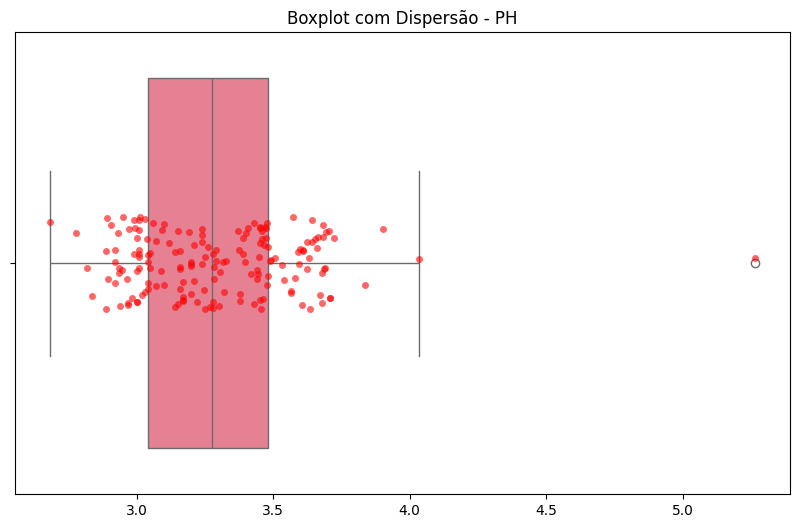

PH: 1 outliers de atributo removidos.
  √çndices Originais Removidos: [56]
  Calibra√ß√£o final: 167 amostras
  Valida√ß√£o: 75 amostras



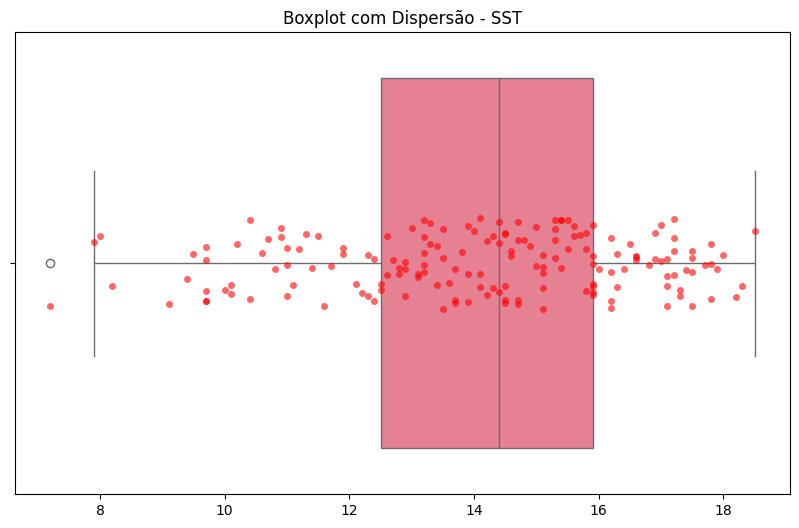

SST: 1 outliers de atributo removidos.
  √çndices Originais Removidos: [30]
  Calibra√ß√£o final: 167 amostras
  Valida√ß√£o: 75 amostras



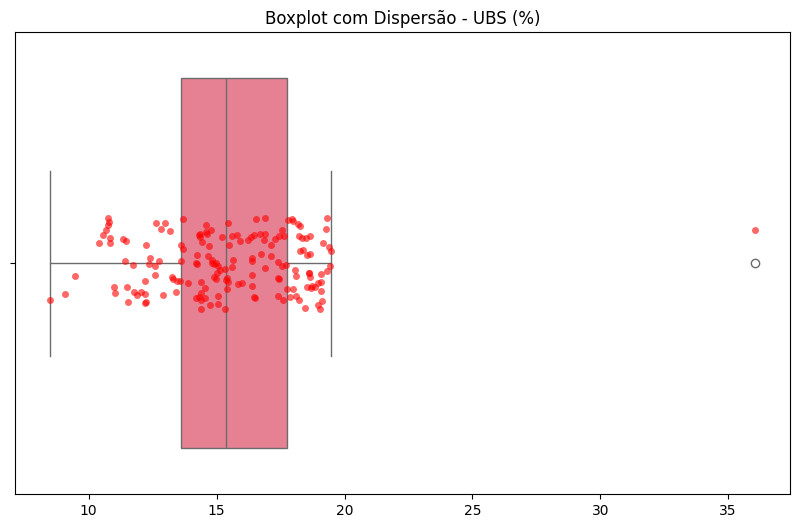

UBS (%): 1 outliers de atributo removidos.
  √çndices Originais Removidos: [242]
  Calibra√ß√£o final: 167 amostras
  Valida√ß√£o: 75 amostras



In [7]:
# Remover outliers dos atributos usando boxplot e IQR
dados_final = {}

for atributo in atributos:
    # Pega os dados j√° limpos de outliers espectrais
    d = dados_pca[atributo]
    X_cal = d['X_cal']
    y_cal = d['y_cal']
    indices_orig_cal = d['indices_orig_cal']
    
    # Boxplot (seu c√≥digo de plotagem original pode ser mantido aqui)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=y_cal)
    sns.stripplot(x=y_cal, color='red', alpha=0.6)
    plt.title(f'Boxplot com Dispers√£o - {atributo}')
    plt.show()

    # L√≥gica de remo√ß√£o de outliers
    Q1 = np.percentile(y_cal, 25)
    Q3 = np.percentile(y_cal, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    keep_mask_attr = (y_cal >= lower_bound) & (y_cal <= upper_bound)
    
    # Identifica e informa os outliers removidos
    outliers_attr_indices = indices_orig_cal[~keep_mask_attr]
    print(f'{atributo}: {len(outliers_attr_indices)} outliers de atributo removidos.')
    if len(outliers_attr_indices) > 0:
        print(f'  √çndices Originais Removidos: {outliers_attr_indices}')
    
    # Armazena os dados finais e limpos para modelagem
    dados_final[atributo] = {
        'X_cal': X_cal[keep_mask_attr],
        'y_cal': y_cal[keep_mask_attr],
        'X_val': dados_divididos[atributo]['X_val'], # Valida√ß√£o original
        'y_val': dados_divididos[atributo]['y_val']   # Valida√ß√£o original
    }
    
    print(f'  Calibra√ß√£o final: {dados_final[atributo]["X_cal"].shape[0]} amostras')
    print(f'  Valida√ß√£o: {dados_final[atributo]["X_val"].shape[0]} amostras')
    print()

## 6. Filtros de Pr√©-processamento (Independentes e Dependentes de y)

Os dados espectrais brutos cont√™m diversas fontes de varia√ß√£o indesejada que podem mascarar a informa√ß√£o qu√≠mica relevante. Essas varia√ß√µes podem ser causadas por espalhamento de luz (efeitos f√≠sicos da amostra), mudan√ßas na linha de base (drift do instrumento) e ru√≠do. O pr√©-processing visa minimizar esses efeitos para que o modelo foque na correla√ß√£o entre o espectro e o atributo de interesse.

Neste notebook, testamos uma ampla gama de filtros, divididos em duas categorias:

### Filtros Independentes de y

S√£o aplicados apenas aos espectros (`X`) e n√£o utilizam a informa√ß√£o da vari√°vel alvo (`y`).

-   **`Raw`**: Utiliza os dados espectrais brutos, sem nenhum tratamento. Serve como uma linha de base para comparar a efic√°cia dos outros filtros.
-   **`MSC` (Multiplicative Scatter Correction)**: Corrige o espalhamento de luz (aditivo e multiplicativo) causado por varia√ß√µes no tamanho de part√≠cula e compacta√ß√£o da amostra. Ele ajusta cada espectro para se parecer mais com um espectro "ideal" (geralmente a m√©dia de todos os espectros).
-   **`SNV` (Standard Normal Variate)**: Alternativa ao MSC que tamb√©m corrige o espalhamento de luz. A diferen√ßa √© que o SNV padroniza cada espectro individualmente (subtrai a m√©dia e divide pelo desvio padr√£o daquele espectro), sem usar um espectro de refer√™ncia.
-   **`SG_D1` e `SG_D2` (Savitzky-Golay Derivatives)**: Calcula a primeira ou a segunda derivada do espectro. Derivadas s√£o excelentes para remover desvios de linha de base (efeitos aditivos) e para resolver picos espectrais sobrepostos, real√ßando a informa√ß√£o de bandas de absor√ß√£o espec√≠ficas.
-   **`Detrend`**: Remove tend√™ncias lineares ou polinomiais da linha de base do espectro. √â muito eficaz para corrigir "inclina√ß√µes" no espectro causadas por drift do instrumento.
-   **`Normalize`**: Realiza uma normaliza√ß√£o Min-Max, escalonando a intensidade de cada espectro para um intervalo fixo (geralmente [0, 1]). Ajuda a corrigir varia√ß√µes de intensidade causadas por diferen√ßas na dist√¢ncia da amostra ou na pot√™ncia da fonte de luz.
-   **`EMSC` (Extended Multiplicative Signal Correction)**: Uma vers√£o avan√ßada do MSC. Al√©m de corrigir os efeitos de espalhamento, o EMSC pode incluir termos polinomiais para modelar e remover efeitos de linha de base mais complexos e n√£o-lineares.
-   **`Continuum Removal`**: T√©cnica que normaliza os espectros para que as bandas de absor√ß√£o possam ser comparadas em termos de sua profundidade, e n√£o de sua intensidade absoluta. Ele ajusta um "envelope" (casco convexo) sobre o espectro e divide o espectro original por este envelope, real√ßando as caracter√≠sticas de absor√ß√£o.
-   **`Wavelet_Denoising`**: Utiliza a Transformada Wavelet para decompor o espectro em diferentes n√≠veis de frequ√™ncia. A t√©cnica permite remover o ru√≠do (geralmente presente em altas frequ√™ncias) de forma muito eficaz, preservando as principais caracter√≠sticas do sinal espectral.

### Filtros Dependentes de y e Combina√ß√µes

Estes filtros utilizam a vari√°vel alvo (`y`) para otimizar a remo√ß√£o de varia√ß√£o n√£o correlacionada em `X`, ou s√£o combina√ß√µes sequenciais de m√∫ltiplos filtros para um tratamento mais completo.

-   **`OSC_1` e `OSC_2` (Orthogonal Signal Correction)**: Filtro que remove componentes (1 ou 2, neste caso) dos espectros `X` que s√£o ortogonais (n√£o correlacionados) √† vari√°vel alvo `y`. O objetivo √© limpar `X` da varia√ß√£o que n√£o ajuda na predi√ß√£o, potencialmente melhorando o modelo subsequente. Esta t√©cnica √© frequentemente referida como um pr√©-processamento **OPLS** (Orthogonal Projections to Latent Structures).
-   **`MSC_SG_OSC`**: Uma **cadeia de pr√©-processamentos** aplicada na seguinte ordem:
    1.  `MSC` para corrigir o espalhamento.
    2.  `Savitzky-Golay (1¬™ derivada)` para corrigir a linha de base.
    3.  `OSC (1 componente)` para remover varia√ß√£o n√£o correlacionada com `y`.
-   **`OPLS1_SNV_SG_D1` e `OPLS2_SNV_SG_D1`**: Outra cadeia de processamento:
    1.  `SNV` para corre√ß√£o de espalhamento.
    2.  `Savitzky-Golay (1¬™ derivada)`.
    3.  `OPLS/OSC` para remover 1 ou 2 componentes ortogonais a `y`.
-   **`SNV_Detrend_SG_D1`**: Uma combina√ß√£o de filtros independentes de `y`, mas que, por sua complexidade, √© testada junto √†s outras cadeias:
    1.  `SNV`.
    2.  `Detrend` para remo√ß√£o de tend√™ncia.
    3.  `Savitzky-Golay (1¬™ derivada)`.

In [8]:
# Implementa√ß√£o dos filtros de pr√©-processamento
# Filtros independentes de y
def msc(X):
    """Multiplicative Scatter Correction."""
    X = np.asarray(X)
    mean_spectrum = np.mean(X, axis=0)
    corrected_spectra = np.zeros_like(X)
    for i in range(X.shape[0]):
        slope, intercept = np.polyfit(mean_spectrum, X[i, :], 1)
        corrected_spectra[i, :] = (X[i, :] - intercept) / slope
    return corrected_spectra

def snv(X):
    """Standard Normal Variate."""
    X = np.asarray(X)
    return (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

def savitzky_golay(X, window_size=11, poly_order=2, deriv_order=1):
    """Savitzky-Golay filter."""
    return savgol_filter(X, window_length=window_size, polyorder=poly_order, deriv=deriv_order, axis=1)

def detrend_filter(X):
    """Detrending filter."""
    return detrend(X, axis=1)

def normalize(X):
    """Normaliza√ß√£o Min-Max."""
    return (X - np.min(X, axis=1, keepdims=True)) / (np.max(X, axis=1, keepdims=True) - np.min(X, axis=1, keepdims=True))

def emsc(X, reference=None):
    """Extended Multiplicative Signal Correction."""
    X = np.asarray(X)
    if reference is None:
        reference = np.mean(X, axis=0)  # Usa o espectro m√©dio como refer√™ncia
    
    X_corr = np.zeros_like(X)
    for i in range(X.shape[0]):
        # Modelo: X[i] ‚âà a + b*reference
        model = np.vstack([np.ones_like(reference), reference]).T
        params, _, _, _ = np.linalg.lstsq(model, X[i, :], rcond=None)
        a, b = params[0], params[1]
        X_corr[i,:] = (X[i, :] - a) / b
    return X_corr

def continuum_removal(X, wavelengths):
    """Continuum Removal."""
    X = np.asarray(X)
    X_cr = np.zeros_like(X)
    for i in range(X.shape[0]):
        spectrum = X[i, :]
        # Encontra os pontos do casco convexo superior
        q_u = [0]
        for k in range(1, len(wavelengths) - 1):
            s_k = (spectrum[len(wavelengths)-1] - spectrum[0]) / (wavelengths[-1] - wavelengths[0])
            s_q = (spectrum[k] - spectrum[q_u[-1]]) / (wavelengths[k] - wavelengths[q_u[-1]])
            if s_q > s_k:
                q_u.append(k)
        q_u.append(len(wavelengths)-1)
        
        # Interpola√ß√£o linear entre os pontos do casco
        continuum = np.interp(wavelengths, wavelengths[q_u], spectrum[q_u])
        X_cr[i, :] = spectrum / continuum
    return X_cr

def wavelet_denoising(X, wavelet='db4', level=4):
    """Wavelet Transform para Denoising."""
    X = np.asarray(X)
    original_length = X.shape[1]
    denoised_list = []

    for i in range(X.shape[0]):
        # 1. Decomposi√ß√£o Wavelet
        coeffs = pywt.wavedec(X[i, :], wavelet, level=level)

        # 2. C√°lculo do limiar (threshold)
        sigma = np.median(np.abs(coeffs[-1])) / 0.6745
        threshold = sigma * np.sqrt(2 * np.log(original_length))

        # 3. Aplica√ß√£o do filtro (soft thresholding) nos coeficientes de detalhe
        coeffs[1:] = [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs[1:]]

        # 4. Reconstru√ß√£o do sinal
        reconstructed_signal = pywt.waverec(coeffs, wavelet)

        # 5. Ajuste do tamanho
        denoised_list.append(reconstructed_signal[:original_length])

    return np.asarray(denoised_list)

# Filtros dependentes de y (Orthogonal Signal Correction)
class OrthogonalCorrection:
    """Orthogonal Signal Correction (OSC)."""
    def __init__(self, n_components=1):
        self.n_components = n_components
    
    def fit_transform(self, X, y):
        X, y = np.asarray(X), np.asarray(y).ravel()
        self.w_ortho_ = []
        self.p_ortho_ = []
        self.X_corr_ = X.copy()
        
        for _ in range(self.n_components):
            pls = PLSRegression(n_components=1)
            pls.fit(self.X_corr_, y)
            t = pls.x_scores_
            w = pls.x_weights_
            p = pls.x_loadings_
            
            # Componente Ortogonal
            w_ortho = p - (np.dot(w.T, p) / np.dot(w.T, w)) * w
            t_ortho = np.dot(self.X_corr_, w_ortho)
            p_ortho = np.dot(t_ortho.T, self.X_corr_) / np.dot(t_ortho.T, t_ortho)
            
            # Remover varia√ß√£o ortogonal
            self.X_corr_ -= np.dot(t_ortho, p_ortho)
            self.w_ortho_.append(w_ortho)
            self.p_ortho_.append(p_ortho)
        
        return self.X_corr_
    
    def transform(self, X):
        X_res = np.asarray(X).copy()
        for i in range(self.n_components):
            t_ortho = np.dot(X_res, self.w_ortho_[i])
            X_res -= np.dot(t_ortho, self.p_ortho_[i])
        return X_res

# Dicion√°rio de filtros independentes de y
filtros_independentes = {
    'Raw': lambda X: X,
    'MSC': msc,
    'SNV': snv,
    'SG_D1': lambda X: savitzky_golay(X, window_size=11, poly_order=2, deriv_order=1),
    'SG_D2': lambda X: savitzky_golay(X, window_size=11, poly_order=2, deriv_order=2),
    'Detrend': detrend_filter,
    'Normalize': normalize,
    'EMSC': emsc,
    'Continuum_Removal': lambda X: continuum_removal(X, wavelength_values),
    'Wavelet_Denoising': wavelet_denoising
}

# Dicion√°rio de filtros dependentes de y
filtros_dependentes = {
    'OSC_1': lambda X, y: OrthogonalCorrection(n_components=1).fit_transform(X, y),
    'OSC_2': lambda X, y: OrthogonalCorrection(n_components=2).fit_transform(X, y),
    'MSC_SG_OSC': lambda X, y: OrthogonalCorrection(n_components=1).fit_transform(
        savitzky_golay(msc(X), window_size=11, poly_order=2, deriv_order=1), y),
    'OPLS1_SNV_SG_D1': lambda X, y: OrthogonalCorrection(n_components=1).fit_transform(
        savitzky_golay(snv(X), window_size=11, poly_order=2, deriv_order=1), y),
    'OPLS2_SNV_SG_D1': lambda X, y: OrthogonalCorrection(n_components=2).fit_transform(
        savitzky_golay(snv(X), window_size=11, poly_order=2, deriv_order=1), y),
    'SNV_Detrend_SG_D1': lambda X, y: savitzky_golay(detrend_filter(snv(X)), window_size=11, poly_order=2, deriv_order=1)
}

print(f'Filtros independentes de y: {list(filtros_independentes.keys())}')
print(f'Filtros dependentes de y: {list(filtros_dependentes.keys())}')
print(f'Total de filtros: {len(filtros_independentes) + len(filtros_dependentes)}')

Filtros independentes de y: ['Raw', 'MSC', 'SNV', 'SG_D1', 'SG_D2', 'Detrend', 'Normalize', 'EMSC', 'Continuum_Removal', 'Wavelet_Denoising']
Filtros dependentes de y: ['OSC_1', 'OSC_2', 'MSC_SG_OSC', 'OPLS1_SNV_SG_D1', 'OPLS2_SNV_SG_D1', 'SNV_Detrend_SG_D1']
Total de filtros: 16


## 7. Avalia√ß√£o dos Filtros e Sele√ß√£o dos Melhores

Esta se√ß√£o automatiza o processo de treinamento, otimiza√ß√£o e avalia√ß√£o do modelo MLP Regressor (Rede Neural). O fluxo √© projetado para testar rigorosamente todas as combina√ß√µes de pr√©-processamento.

-   **Fluxo de Trabalho Automatizado:**
    1.  **Itera√ß√£o por Atributo e Filtro:** O c√≥digo itera sobre cada atributo e, para cada um, aplica todos os 16 filtros de pr√©-processamento definidos anteriormente.
    2.  **Padroniza√ß√£o dos Dados:** √â **essencial** escalar os dados (`StandardScaler`) antes de alimentar uma rede neural. Isso garante que o modelo convirja de forma mais r√°pida e est√°vel.
    3.  **Otimiza√ß√£o de Hiperpar√¢metros (`GridSearchCV`):** Para cada filtro, uma busca em grade otimiza os principais hiperpar√¢metros do MLPR, como a arquitetura das camadas ocultas (`hidden_layer_sizes`), a fun√ß√£o de ativa√ß√£o e o m√©todo de otimiza√ß√£o (`solver`).
    4.  **Avalia√ß√£o e Salvamento:** O melhor modelo de cada combina√ß√£o √© avaliado no conjunto de valida√ß√£o. As m√©tricas de desempenho, os melhores par√¢metros e os gr√°ficos de predi√ß√£o vs. real s√£o salvos automaticamente para an√°lise posterior.

In [9]:
# --- Fun√ß√£o para o Gr√°fico de CALIBRA√á√ÉO (Ref vs Predito vs CV) ---
def save_calibration_plot(y_cal, y_pred_cal, y_pred_cv, atributo, filtro, modelo, file_path):
    """
    Gera e salva um gr√°fico comparando predi√ß√µes de treino e de valida√ß√£o cruzada
    no conjunto de calibra√ß√£o.
    """
    try:
        # Garante que o diret√≥rio exista
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        # M√©tricas para Predi√ß√£o no Treino Completo
        slope_pred, offset_pred = np.polyfit(y_cal, y_pred_cal, 1)
        rmse_pred = np.sqrt(mean_squared_error(y_cal, y_pred_cal))
        r2_pred = r2_score(y_cal, y_pred_cal)

        # M√©tricas para Predi√ß√£o da Valida√ß√£o Cruzada
        slope_cv, offset_cv = np.polyfit(y_cal, y_pred_cv, 1)
        rmse_cv = np.sqrt(mean_squared_error(y_cal, y_pred_cv))
        r2_cv = r2_score(y_cal, y_pred_cv)

        plt.figure(figsize=(10, 8))
        plt.scatter(y_cal, y_pred_cal, color='blue', marker='o', alpha=0.6, label=f'Predi√ß√£o no Treino (R¬≤={r2_pred:.3f})')
        plt.scatter(y_cal, y_pred_cv, color='red', marker='x', alpha=0.7, label=f'Predi√ß√£o CV (R¬≤={r2_cv:.3f})')
        
        # Linha ideal 1:1
        min_val = min(min(y_cal), min(y_pred_cal), min(y_pred_cv))
        max_val = max(max(y_cal), max(y_pred_cal), max(y_pred_cv))
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Linha Ideal (1:1)')

        plt.xlabel("Valores Reais (Calibra√ß√£o)")
        plt.ylabel("Valores Preditos")
        plt.title(f'Desempenho na Calibra√ß√£o: {atributo} | {modelo} | {filtro}')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(loc='lower right')
        
        # Adiciona texto com m√©tricas
        stats_text = (
            f'Treino - RMSE: {rmse_pred:.3f}, Slope: {slope_pred:.3f}, Offset: {offset_pred:.3f}\n'
            f'CV     - RMSE: {rmse_cv:.3f}, Slope: {slope_cv:.3f}, Offset: {offset_cv:.3f}'
        )
        plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=10,
                 verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

        plt.savefig(file_path, format='png', dpi=200, bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"Erro ao gerar gr√°fico de calibra√ß√£o para {modelo} com {filtro}: {e}")
        plt.close()


# --- Fun√ß√£o para o Gr√°fico de VALIDA√á√ÉO (Predito vs Real) ---
def save_validation_plot(y_val, y_pred_val, atributo, filtro, modelo, file_path):
    """
    Gera e salva o gr√°fico de predi√ß√µes no conjunto de valida√ß√£o (teste).
    """
    try:
        # Garante que o diret√≥rio exista
        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        
        # M√©tricas
        r2 = r2_score(y_val, y_pred_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        slope, offset = np.polyfit(y_val, y_pred_val, 1)

        plt.figure(figsize=(8, 8))
        plt.scatter(y_val, y_pred_val, alpha=0.7, edgecolors='k', label='Dados de Valida√ß√£o')
        
        # Linha ideal 1:1
        min_val = min(min(y_val), min(y_pred_val))
        max_val = max(max(y_val), max(y_pred_val))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Linha Ideal (1:1)')

        plt.xlabel('Valores Reais (Valida√ß√£o)')
        plt.ylabel('Valores Preditos')
        plt.title(f'Desempenho na Valida√ß√£o: {atributo} | {modelo} | {filtro}')
        plt.grid(True, linestyle='--', alpha=0.6)
        
        stats_text = f'R¬≤ = {r2:.4f}\nRMSE = {rmse:.4f}\nSlope = {slope:.4f}'
        plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=12,
                 verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5))
        
        plt.legend()
        plt.savefig(file_path, format='png', dpi=200, bbox_inches='tight')
        plt.close()

    except Exception as e:
        print(f"Erro ao gerar gr√°fico de valida√ß√£o para {modelo} com {filtro}: {e}")
        plt.close()

In [10]:
# 1. Definir o modelo MLPR e seu grid de par√¢metros
# (Grid menor para um teste mais r√°pido, pode ser expandido)
param_grid_mlpr = {
    'hidden_layer_sizes': [
        (120, 10,1),
        (5,), (8,), (12,), (30,),
        (10,), (15,), (20,), (25,), (32,),
        (20, 10), (32, 16), (64, 32), (50, 20),
        (20, 15, 10),
        (16, 8), (20, 20),
        
        ],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam'],
    'early_stopping': [True],
    'max_iter': [1000]
}

# Combina todos os filtros
todos_filtros = {**filtros_independentes, **filtros_dependentes}

# Lista para armazenar todos os resultados
lista_resultados_finais_mlpr = []
os.makedirs('graficos_mlpr', exist_ok=True) # Cria pasta para salvar gr√°ficos

# 2. Loop principal de modelagem
for atributo in atributos:
    print(f'\n{"="*30}')
    print(f'INICIANDO MODELAGEM MLPR PARA: {atributo}')
    print(f'{"="*30}')
    
    dados = dados_final[atributo]
    X_cal, y_cal = dados['X_cal'], dados['y_cal']
    X_val, y_val = dados['X_val'], dados['y_val']

    # √â crucial escalar os dados para o MLPR
    scaler = StandardScaler()
    X_cal_scaled = scaler.fit_transform(X_cal)
    X_val_scaled = scaler.transform(X_val)

    for nome_filtro, funcao_filtro in todos_filtros.items():
        start_time = time.time()
        print(f'  Testando filtro: {nome_filtro}...', end='')

        # Aplicar filtro aos dados j√° escalados
        if nome_filtro in filtros_independentes:
            X_cal_f = funcao_filtro(X_cal_scaled)
            X_val_f = funcao_filtro(X_val_scaled)
        else: # Filtro dependente de Y
            osc_model = OrthogonalCorrection(n_components=1)
            X_cal_f = osc_model.fit_transform(X_cal_scaled, y_cal)
            X_val_f = osc_model.transform(X_val_scaled)
        
        # GridSearchCV
        mlpr = MLPRegressor(random_state=42)
        grid = GridSearchCV(mlpr, param_grid_mlpr, cv=5, scoring='r2', n_jobs=-1, verbose=0)
        grid.fit(X_cal_f, y_cal)
        
        melhor_modelo = grid.best_estimator_
        
        # Avalia√ß√£o final no conjunto de valida√ß√£o
        y_pred = melhor_modelo.predict(X_val_f)
        r2_val = r2_score(y_val, y_pred)
        rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))
        
        end_time = time.time()
        print(f' R¬≤ Val: {r2_val:.4f} | Conclu√≠do em {end_time - start_time:.2f}s')
        
        # Salvar resultados
        lista_resultados_finais_mlpr.append({
            'Atributo': atributo,
            'Modelo': 'MLPR',
            'Filtro': nome_filtro,
            'CV_R2': grid.best_score_,
            'Val_R2': r2_val,
            'Val_RMSE': rmse_val,
            'Melhores_Params': str(grid.best_params_),
            'Tempo_s': end_time - start_time
        })
        
        # --- L√≥gica de plotagem nova e aprimorada para MLPR ---

        # 1. Gera as predi√ß√µes necess√°rias para os gr√°ficos
        y_pred_cal = melhor_modelo.predict(X_cal_f)
        # Para o CV do MLPR, usamos um modelo base para agilizar
        base_mlpr = MLPRegressor(random_state=42, max_iter=1000) 
        y_pred_cv = cross_val_predict(base_mlpr, X_cal_f, y_cal, cv=5)

        # 2. Chama a fun√ß√£o para o gr√°fico de CALIBRA√á√ÉO
        path_cal = f'graficos_mlpr/calibracao/{atributo}_MLPR_{nome_filtro}.png'
        save_calibration_plot(y_cal, y_pred_cal, y_pred_cv, atributo, nome_filtro, 'MLPR', path_cal)

        # 3. Chama a fun√ß√£o para o gr√°fico de VALIDA√á√ÉO
        #    (y_pred j√° foi calculado antes como a predi√ß√£o em y_val)
        path_val = f'graficos_mlpr/validacao/{atributo}_MLPR_{nome_filtro}.png'
        save_validation_plot(y_val, y_pred, atributo, nome_filtro, 'MLPR', path_val)

print('\n\n‚úÖ Modelagem MLPR exaustiva conclu√≠da!')

# 3. Criar DataFrame e exportar para Excel
df_mlpr = pd.DataFrame(lista_resultados_finais_mlpr)
df_mlpr_ordenado = df_mlpr.sort_values(by=['Atributo', 'Val_R2'], ascending=[True, False])
df_mlpr_ordenado.to_excel('resultados_modelagem_mlpr.xlsx', index=False)

print('‚úÖ Resultados salvos em "resultados_modelagem_mlpr.xlsx"')

# 4. Exibir melhores resultados
print("\n--- Melhores Resultados por Atributo (MLPR) ---")
melhores_mlpr = df_mlpr_ordenado.groupby('Atributo').first().reset_index()
colunas_numericas_para_arredondar = ['Val_R2', 'Val_RMSE']
melhores_mlpr[colunas_numericas_para_arredondar] = melhores_mlpr[colunas_numericas_para_arredondar].round(4)

colunas_para_exibir = ['Atributo', 'Filtro', 'Val_R2', 'Val_RMSE', 'Melhores_Params']
print(melhores_mlpr[colunas_para_exibir])


INICIANDO MODELAGEM MLPR PARA: AT
  Testando filtro: Raw... R¬≤ Val: 0.4361 | Conclu√≠do em 200.59s
  Testando filtro: MSC... R¬≤ Val: -0.0767 | Conclu√≠do em 200.40s
  Testando filtro: SNV... R¬≤ Val: 0.4099 | Conclu√≠do em 239.67s
  Testando filtro: SG_D1... R¬≤ Val: 0.4502 | Conclu√≠do em 258.61s
  Testando filtro: SG_D2... R¬≤ Val: 0.2296 | Conclu√≠do em 251.02s
  Testando filtro: Detrend... R¬≤ Val: 0.4524 | Conclu√≠do em 225.07s
  Testando filtro: Normalize... R¬≤ Val: 0.2797 | Conclu√≠do em 169.83s
  Testando filtro: EMSC... R¬≤ Val: -0.0652 | Conclu√≠do em 90.68s
  Testando filtro: Continuum_Removal... R¬≤ Val: -0.0477 | Conclu√≠do em 97.72s
  Testando filtro: Wavelet_Denoising... R¬≤ Val: 0.4248 | Conclu√≠do em 198.60s
  Testando filtro: OSC_1... R¬≤ Val: 0.4201 | Conclu√≠do em 240.00s
  Testando filtro: OSC_2... R¬≤ Val: 0.4201 | Conclu√≠do em 234.80s
  Testando filtro: MSC_SG_OSC... R¬≤ Val: 0.4201 | Conclu√≠do em 238.87s
  Testando filtro: OPLS1_SNV_SG_D1... R¬≤ Val: 0.420

## 8. Explora√ß√£o Aprofundada dos Melhores Filtros com Ajuste de Par√¢metros

Nesta se√ß√£o, realizamos uma nova rodada de modelagem utilizando apenas os melhores filtros identificados na an√°lise anterior. Para filtros que aceitam par√¢metros ajust√°veis (como Savitzky-Golay, Wavelet Denoising e OSC), testamos m√∫ltiplas combina√ß√µes desses par√¢metros a fim de maximizar a performance do modelo. Usamos novamente uma abordagem com GridSearch para o MLPRegressor e reportamos os melhores par√¢metros de cada combina√ß√£o. Al√©m disso, geramos gr√°ficos de calibra√ß√£o e valida√ß√£o para facilitar a interpreta√ß√£o visual dos resultados.

In [ ]:
print("="*50)
print("üî¨ INICIANDO OTIMIZA√á√ÉO FINA DOS MELHORES FILTROS üî¨")
print("="*50)

# 1. Selecionar os melhores filtros identificados na an√°lise anterior
melhores_filtros_por_atributo = {
    'AT': ['Detrend', 'Normalize', 'Raw', 'Wavelet_Denoising', 'OSC_1', 'MSC', 'EMSC', 'OSC_2'],
    'FIRMEZA (N)': ['EMSC', 'MSC', 'Wavelet_Denoising', 'Raw', 'SNV', 'Detrend', 'Normalize', 'OSC_1'],
    'PH': ['OSC_1', 'Detrend', 'Raw', 'Wavelet_Denoising', 'OSC_2', 'SG_D1', 'SNV', 'SG_D1'],
    'SST': ['SNV_Detrend_SG_D1', 'OPLS2_SNV_SG_D1', 'Detrend', 'SNV', 'OSC_1', 'OPLS1_SNV_SG_D1'],
    'UBS (%)': ['OPLS2_SNV_SG_D1', 'SNV_Detrend_SG_D1', 'OPLS1_SNV_SG_D1', 'MSC_SG_OSC', 'SNV']
}

# 2. Definir os grids de par√¢metros para os filtros que aceitam otimiza√ß√£o
sg_params_to_test = {
    'window_size': [5, 11, 15, 21, 27, 35, 41],
        'poly_order': [2, 3, 4],
        'deriv_order': [1, 2]
}

osc_params_to_test = {
    'n_components': [1, 2, 3]
}

wavelet_params_to_test = {
    'wavelet': ['db1', 'db2', 'db3', 'db4', 'db5'],
    'level': [1,2, 3, 4, 5]
}

# 3. Definir o grid do modelo MLPR (o mesmo de antes)
param_grid_mlpr = {
    'hidden_layer_sizes': [
        (120, 10,1),
        (5,), (8,), (12,), (30,),
        (10,), (15,), (20,), (25,), (32,),
        (20, 10), (32, 16), (64, 32), (50, 20),
        (20, 15, 10),
        (16, 8), (20, 20),
        
        ],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam'],
    'early_stopping': [True],
    'max_iter': [1000]
}

# Lista para armazenar os novos resultados
lista_resultados_otimizados_mlpr = []

# 4. Loop principal de modelagem e otimiza√ß√£o
for atributo, lista_melhores_filtros in melhores_filtros_por_atributo.items():
    print(f'\n{"="*30}')
    print(f'OTIMIZANDO FILTROS PARA: {atributo}')
    print(f'{"="*30}')
    
    # Carregar dados (assumindo que 'dados_final' est√° dispon√≠vel)
    dados = dados_final[atributo]
    X_cal, y_cal = dados['X_cal'], dados['y_cal']
    X_val, y_val = dados['X_val'], dados['y_val']

    # Escalar os dados brutos uma √∫nica vez
    scaler = StandardScaler()
    X_cal_scaled = scaler.fit_transform(X_cal)
    X_val_scaled = scaler.transform(X_val)

    for nome_filtro in lista_melhores_filtros:
        print(f'\n--- Otimizando filtro: {nome_filtro} ---')
        start_time_total = time.time()
        
        # Vari√°veis para guardar o melhor resultado para ESTE filtro
        melhor_resultado_do_filtro = {
            'Val_R2': -np.inf, 
            'Val_RMSE': np.inf,
            'Melhores_Params_Filtro': 'N/A',
            'Melhores_Params_Modelo': None,
            'Tempo_s': 0
        }
        
        # L√≥gica para aplicar os grids de par√¢metros dos filtros
        
        # CASO 1: Filtros que usam Savitzky-Golay (SG) e OSC/OPLS
        if ('SG' in nome_filtro) and ('OSC' in nome_filtro or 'OPLS' in nome_filtro):
            print(f'  (Grid Search em SG e OSC/OPLS ativado)')
            sg_grid = ParameterGrid(sg_params_to_test)
            
            for n_comp in osc_params_to_test['n_components']:
                for sg_p in sg_grid:
                    # Evitar combina√ß√£o inv√°lida
                    if sg_p['poly_order'] >= sg_p['window_size']:
                        continue
                        
                    params_filtro_str = f"OSC_n_comp={n_comp}, SG_params={sg_p}"
                    print(f'    Testando: {params_filtro_str}...', end='')
                    start_time_iter = time.time()
                    
                    try:
                        # Aplicar pr√©-filtros (SNV, etc.)
                        X_cal_pre, X_val_pre = snv(X_cal_scaled), snv(X_val_scaled)
                        # Aplicar SG
                        X_cal_sg = savitzky_golay(X_cal_pre, **sg_p)
                        X_val_sg = savitzky_golay(X_val_pre, **sg_p)
                        # Aplicar OSC/OPLS
                        osc_model = OrthogonalCorrection(n_components=n_comp)
                        X_cal_f = osc_model.fit_transform(X_cal_sg, y_cal)
                        X_val_f = osc_model.transform(X_val_sg)
                    except Exception as e:
                        print(f" Erro ao aplicar filtro: {e}")
                        continue

                    # Roda o GridSearchCV para o MLPR
                    mlpr = MLPRegressor(random_state=42)
                    grid = GridSearchCV(mlpr, param_grid_mlpr, cv=5, scoring='r2', n_jobs=-1)
                    grid.fit(X_cal_f, y_cal)
                    
                    # Avalia√ß√£o
                    y_pred = grid.best_estimator_.predict(X_val_f)
                    r2_val = r2_score(y_val, y_pred)
                    
                    print(f' R¬≤ Val: {r2_val:.4f}')
                    
                    # Atualiza se o resultado for melhor
                    if r2_val > melhor_resultado_do_filtro['Val_R2']:
                        melhor_resultado_do_filtro['Val_R2'] = r2_val
                        melhor_resultado_do_filtro['Val_RMSE'] = np.sqrt(mean_squared_error(y_val, y_pred))
                        melhor_resultado_do_filtro['Melhores_Params_Filtro'] = params_filtro_str
                        melhor_resultado_do_filtro['Melhores_Params_Modelo'] = str(grid.best_params_)
            
        # CASO 2: Filtros que usam S√ì Savitzky-Golay (SG)
        elif 'SG' in nome_filtro:
            print(f'  (Grid Search em SG ativado)')
            sg_grid = ParameterGrid(sg_params_to_test)
            for sg_p in sg_grid:
                 if sg_p['poly_order'] >= sg_p['window_size']:
                        continue
                
                 params_filtro_str = f"SG_params={sg_p}"
                 print(f'    Testando: {params_filtro_str}...', end='')

                 try:
                    # Aplicar pr√©-filtros
                    X_cal_pre, X_val_pre = snv(X_cal_scaled), snv(X_val_scaled)
                    X_cal_pre, X_val_pre = detrend_filter(X_cal_pre), detrend_filter(X_val_pre)
                    # Aplicar SG
                    X_cal_f = savitzky_golay(X_cal_pre, **sg_p)
                    X_val_f = savitzky_golay(X_val_pre, **sg_p)
                 except Exception as e:
                    print(f" Erro ao aplicar filtro: {e}")
                    continue

                 mlpr = MLPRegressor(random_state=42)
                 grid = GridSearchCV(mlpr, param_grid_mlpr, cv=5, scoring='r2', n_jobs=-1)
                 grid.fit(X_cal_f, y_cal)
                 y_pred = grid.best_estimator_.predict(X_val_f)
                 r2_val = r2_score(y_val, y_pred)
                 print(f' R¬≤ Val: {r2_val:.4f}')
                 if r2_val > melhor_resultado_do_filtro['Val_R2']:
                    melhor_resultado_do_filtro['Val_R2'] = r2_val
                    melhor_resultado_do_filtro['Val_RMSE'] = np.sqrt(mean_squared_error(y_val, y_pred))
                    melhor_resultado_do_filtro['Melhores_Params_Filtro'] = params_filtro_str
                    melhor_resultado_do_filtro['Melhores_Params_Modelo'] = str(grid.best_params_)

        # CASO 3: Filtros que usam S√ì OSC/OPLS (e n√£o SG)
        elif 'OSC' in nome_filtro:
            print(f'  (Grid Search em OSC ativado)')
            for n_comp in osc_params_to_test['n_components']:
                params_filtro_str = f"OSC_n_comp={n_comp}"
                print(f'    Testando: {params_filtro_str}...', end='')
                
                osc_model = OrthogonalCorrection(n_components=n_comp)
                X_cal_f = osc_model.fit_transform(X_cal_scaled, y_cal)
                X_val_f = osc_model.transform(X_val_scaled)
                
                mlpr = MLPRegressor(random_state=42)
                grid = GridSearchCV(mlpr, param_grid_mlpr, cv=5, scoring='r2', n_jobs=-1)
                grid.fit(X_cal_f, y_cal)
                y_pred = grid.best_estimator_.predict(X_val_f)
                r2_val = r2_score(y_val, y_pred)
                print(f' R¬≤ Val: {r2_val:.4f}')
                if r2_val > melhor_resultado_do_filtro['Val_R2']:
                    melhor_resultado_do_filtro['Val_R2'] = r2_val
                    melhor_resultado_do_filtro['Val_RMSE'] = np.sqrt(mean_squared_error(y_val, y_pred))
                    melhor_resultado_do_filtro['Melhores_Params_Filtro'] = params_filtro_str
                    melhor_resultado_do_filtro['Melhores_Params_Modelo'] = str(grid.best_params_)

        # CASO 4: Filtros n√£o parametriz√°veis (rodam apenas uma vez)
        else:
            print(f'  (Filtro n√£o parametriz√°vel, rodando com configura√ß√£o padr√£o)')
            # Aplica o filtro (aqui usamos um dicion√°rio para chamar a fun√ß√£o certa)
            filtros_nao_parametrizaveis = {
                'Detrend': detrend_filter,
                'Normalize': normalize,
                'EMSC': emsc,
                'MSC': msc,
                'SNV': snv # Adicionado para completude
            }
            funcao_filtro = filtros_nao_parametrizaveis.get(nome_filtro, lambda x: x)
            X_cal_f = funcao_filtro(X_cal_scaled)
            X_val_f = funcao_filtro(X_val_scaled)
            
            mlpr = MLPRegressor(random_state=42)
            grid = GridSearchCV(mlpr, param_grid_mlpr, cv=5, scoring='r2', n_jobs=-1)
            grid.fit(X_cal_f, y_cal)
            y_pred = grid.best_estimator_.predict(X_val_f)
            
            melhor_resultado_do_filtro['Val_R2'] = r2_score(y_val, y_pred)
            melhor_resultado_do_filtro['Val_RMSE'] = np.sqrt(mean_squared_error(y_val, y_pred))
            melhor_resultado_do_filtro['Melhores_Params_Modelo'] = str(grid.best_params_)

        # Armazenar o melhor resultado encontrado para o filtro atual
        end_time_total = time.time()
        lista_resultados_otimizados_mlpr.append({
            'Atributo': atributo,
            'Modelo': 'MLPR',
            'Filtro': nome_filtro,
            'Val_R2': melhor_resultado_do_filtro['Val_R2'],
            'Val_RMSE': melhor_resultado_do_filtro['Val_RMSE'],
            'Melhores_Params_Filtro': melhor_resultado_do_filtro['Melhores_Params_Filtro'],
            'Melhores_Params_Modelo': melhor_resultado_do_filtro['Melhores_Params_Modelo'],
            'Tempo_s': end_time_total - start_time_total
        })
        
        print(f'--- Melhor resultado para {nome_filtro}: R¬≤ = {melhor_resultado_do_filtro["Val_R2"]:.4f} ---')
        print(f'    Par√¢metros do Filtro: {melhor_resultado_do_filtro["Melhores_Params_Filtro"]}')
        print(f'    Par√¢metros do Modelo: {melhor_resultado_do_filtro["Melhores_Params_Modelo"]}')
        
print('\n\n‚úÖOtimiza√ß√£o Fina conclu√≠da!')

# 5. Criar DataFrame e exportar os resultados otimizados
df_mlpr_otimizado = pd.DataFrame(lista_resultados_otimizados_mlpr)
df_mlpr_otimizado_ordenado = df_mlpr_otimizado.sort_values(by=['Atributo', 'Val_R2'], ascending=[True, False])
df_mlpr_otimizado_ordenado.to_excel('resultados_otimizacao_filtros_mlpr.xlsx', index=False)

print('‚úÖ Resultados da otimiza√ß√£o salvos em "resultados_otimizacao_filtros_mlpr.xlsx"')

# 6. Exibir melhores resultados da otimiza√ß√£o
print("\n--- Melhores Resultados por Atributo (Ap√≥s Otimiza√ß√£o de Filtros) ---")
melhores_otimizados_mlpr = df_mlpr_otimizado_ordenado.groupby('Atributo').first().reset_index()
print(melhores_otimizados_mlpr[['Atributo', 'Filtro', 'Val_R2', 'Val_RMSE', 'Melhores_Params_Filtro']].round(4))

üî¨ INICIANDO OTIMIZA√á√ÉO FINA DOS MELHORES FILTROS üî¨

OTIMIZANDO FILTROS PARA: AT

--- Otimizando filtro: Detrend ---
  (Filtro n√£o parametriz√°vel, rodando com configura√ß√£o padr√£o)
--- Melhor resultado para Detrend: R¬≤ = 0.4524 ---
    Par√¢metros do Filtro: N/A
    Par√¢metros do Modelo: {'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (25,), 'max_iter': 1000, 'solver': 'adam'}

--- Otimizando filtro: Normalize ---
  (Filtro n√£o parametriz√°vel, rodando com configura√ß√£o padr√£o)
--- Melhor resultado para Normalize: R¬≤ = 0.2797 ---
    Par√¢metros do Filtro: N/A
    Par√¢metros do Modelo: {'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (20, 15, 10), 'max_iter': 1000, 'solver': 'adam'}

--- Otimizando filtro: Raw ---
  (Filtro n√£o parametriz√°vel, rodando com configura√ß√£o padr√£o)
--- Melhor resultado para Raw: R¬≤ = 0.4361 ---
    Par√¢metros do Filtro: N/A
    Par√¢metros do Modelo: {'acti